In [1]:
%pylab inline
import numpy as np
import torch
import os

from utils import *
from ipdb import set_trace
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable
import nibabel as nib
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader
from nilearn import plotting
from ADNI_dataset import *
from BRATS_dataset import *
from ATLAS_dataset import *
from Model_WGAN import *

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
BATCH_SIZE=4
max_epoch = 100
lr = 0.0001
gpu = True
workers = 4

LAMBDA= 10
#setting latent variable sizes
latent_dim = 1000

In [3]:
trainset = ADNIdataset(augmentation=True)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
# if Use_BRATS:
#     #'flair' or 't2' or 't1ce'
#     trainset = BRATSdataset(imgtype='flair')
#     train_loader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle=True,
#                                                num_workers=workers)
# if Use_ATLAS:
#     trainset = ATLASdataset(augmentation=True)
#     train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)

def inf_train_gen(data_loader):
    while True:
        for _,images in enumerate(data_loader):
            yield images


In [4]:
D = Discriminator()
G = Generator(noise = latent_dim)

D.cuda()
G.cuda()

g_optimizer = optim.Adam(G.parameters(), lr=0.0002)
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)

In [5]:
def calc_gradient_penalty(netD, real_data, fake_data):    
    alpha = torch.rand(real_data.size(0),1,1,1,1)
    alpha = alpha.expand(real_data.size())
    
    alpha = alpha.cuda()

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    interpolates = interpolates.cuda()
    interpolates = Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda(),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

# Training

In [6]:
real_y = Variable(torch.ones((BATCH_SIZE, 1)).cuda())
fake_y = Variable(torch.zeros((BATCH_SIZE, 1)).cuda())
loss_f = nn.BCELoss()

d_real_losses = list()
d_fake_losses = list()
d_losses = list()
g_losses = list()
divergences = list()


df = load_loss()
init_iter = w_load_checkpoint(G, D, '_W_iter')

/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


[0/200000] D: 7.62     D_real: 5.26     D_fake: 2.94     G: -2.41   


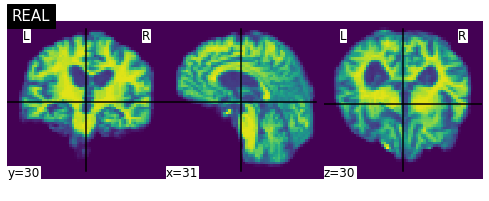

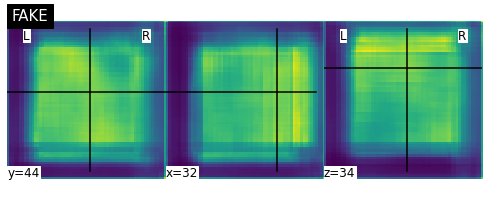

In [ ]:
TOTAL_ITER = 200000
gen_load = inf_train_gen(train_loader)
for iteration in range(init_iter, TOTAL_ITER):
    ###############################################
    # Train D 
    ###############################################
    for p in D.parameters():  
        p.requires_grad = True 

    real_images = gen_load.__next__()
    D.zero_grad()
    real_images = Variable(real_images).cuda()

    _batch_size = real_images.size(0)


    y_real_pred = D(real_images)

    d_real_loss = y_real_pred.mean()
    
    noise = Variable(torch.randn((_batch_size, latent_dim, 1, 1, 1)),volatile=True).cuda()
    fake_images = G(noise)
    y_fake_pred = D(fake_images.detach())

    d_fake_loss = y_fake_pred.mean()

    gradient_penalty = calc_gradient_penalty(D,real_images.data, fake_images.data)

    d_loss = - d_real_loss + d_fake_loss +gradient_penalty
    d_loss.backward()
    Wasserstein_D = d_real_loss - d_fake_loss

    d_optimizer.step()

    ###############################################
    # Train G 
    ###############################################
    for p in D.parameters():
        p.no_grad()
        
    for iters in range(5):
        G.zero_grad()
        noise = Variable(torch.randn((_batch_size, latent_dim, 1, 1 ,1)).cuda())
        fake_image =G(noise)
        y_fake_g = D(fake_image)

        g_loss = -y_fake_g.mean()

        g_loss.backward()
        g_optimizer.step()

    ###############################################
    # Visualization
    ###############################################
    if iteration%500 == 0:
        d_real_losses.append(d_real_loss.item())
        d_fake_losses.append(d_fake_loss.item())
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        print('[{}/{}]'.format(iteration,TOTAL_ITER),
              'D: {:<8.3}'.format(d_loss.item()), 
              'D_real: {:<8.3}'.format(d_real_loss.item()),
              'D_fake: {:<8.3}'.format(d_fake_loss.item()), 
              'G: {:<8.3}'.format(g_loss.item()))
        
        featmask = real_images[0][0]
        featmask = nib.Nifti1Image(np.array(featmask.cpu()),affine = np.eye(4))
        plotting.plot_img(featmask,title="REAL")
        featmask = np.squeeze((0.5*fake_image+0.5)[0])        
        featmask = nib.Nifti1Image(np.array(featmask.cpu().detach().numpy()),affine = np.eye(4))
        plotting.plot_img(featmask,title="FAKE")
        plotting.show()
        
    if (iteration+1)%500 ==0:
        torch.save(G.state_dict(),'./checkpoint/G_W_iter'+str(iteration+1)+'.pth')
        torch.save(D.state_dict(),'./checkpoint/D_W_iter'+str(iteration+1)+'.pth')
        
        df = add_loss(df, iteration, g_loss.item())
        write_loss(df)